In [42]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_validate
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV



## Credit Risk Prediction Project


The risk in credit and lending provided by banks to individuals lies in the potential for default, where the borrower is unable to fully repay their loans. Banks must therefore assess whether individuals have the capacity to reinburse thier loans to ensure that these financial investments yeild positive outcomes. This is important for ensuring sound financial decision-making. 

The goal of this project is to develop a model that assesses whether an individual is likely to fail to repay thier debts on time. This credit scoring algorithm will be implemented as a supervised machine learning classification task, using the "Give Me Some Credit" dataset provided by Kaggle (1). 

This dataset provides relevant features such as prior failure to repay loans on time, monthly income, lines of credit, number of dependents and number of current loans. The model will predict the whether an indivisual will experience a delinquency of 90 days or worse. Amoung the features, the most indicative of credit default is expected to be previous occurances of financial stress, demonstrated by repeated failures to repay loans on time. 

(1) Credit Fusion and Will Cukierski. Give Me Some Credit. https://kaggle.com/competitions/GiveMeSomeCredit, 2011. Kaggle.

In [3]:
credit_traindf = pd.read_csv("data/cs-training.csv")
credit_testdf = pd.read_csv("data/cs-test.csv")

In [4]:
credit_traindf

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


#### **Dataset Cleaning :**
To simplify downstream analysis, feature names were shortened and renamed. Additionally, a column labeled 'Unnamed: 0' was removed from the dataset, as it appears to be an artifact or mistake.

In [5]:
new_columns = {
    "SeriousDlqin2yrs" : "target",
    "RevolvingUtilizationOfUnsecuredLines" : "credit_util_ratio",
    "NumberOfTime30-59DaysPastDueNotWorse" : "mod_late_count_2yr",
    "DebtRatio": "debt_ratio",
    "MonthlyIncome" : "monthly_income",
    "NumberOfOpenCreditLinesAndLoans" : "credit_loans_count", 
    "NumberOfTimes90DaysLate" : "crit_late_count", 
    "NumberRealEstateLoansOrLines" : "real_estate_count",
    "NumberOfTime60-89DaysPastDueNotWorse"  :"sev_late_count_2yr",
    "NumberOfDependents" : "dependent_count"
}


credit_traindf = credit_traindf.rename(columns = new_columns)
credit_testdf = credit_testdf.rename(columns = new_columns)

credit_traindf

,Unnamed: 0,target,credit_util_ratio,age,mod_late_count_2yr,debt_ratio,monthly_income,credit_loans_count,crit_late_count,real_estate_count,sev_late_count_2yr,dependent_count
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [6]:
credit_traindf = credit_traindf.drop(columns = ["Unnamed: 0"])
credit_testdf = credit_testdf.drop(columns = ["Unnamed: 0"])

credit_traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   target              150000 non-null  int64  
 1   credit_util_ratio   150000 non-null  float64
 2   age                 150000 non-null  int64  
 3   mod_late_count_2yr  150000 non-null  int64  
 4   debt_ratio          150000 non-null  float64
 5   monthly_income      120269 non-null  float64
 6   credit_loans_count  150000 non-null  int64  
 7   crit_late_count     150000 non-null  int64  
 8   real_estate_count   150000 non-null  int64  
 9   sev_late_count_2yr  150000 non-null  int64  
 10  dependent_count     146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [7]:
rel = ((credit_traindf["debt_ratio"] > 1) & credit_traindf["monthly_income"].isna()).sum()
nan_count = credit_traindf["monthly_income"].isna().sum()
greater_1 = (credit_traindf["debt_ratio"] > 1).sum()

print(f"There are {rel} instances where debt ratio is above 1 and monthly income is NaN")
print(f"There are {nan_count} total instances of NaN in the monthly income feature")
print(f"There are {greater_1} total instances of a debt ratio of > 1")

There are 27904 instances where debt ratio is above 1 and monthly income is NaN
There are 29731 total instances of NaN in the monthly income feature
There are 35137 total instances of a debt ratio of > 1


#### **Observations :**

- The dataset is large, with 150,000 rows and all numerical features.
- credit_util_ratio, debt_ratio, and monthly_income are continuous variables and may require scaling. The remaining features are discrete.
- debt_ratio and credit_util_ratio containg some values over 1, which is unusual and could indicate outliers/data entry errors.
- Missing values are present in both monthly_income and dependents_count.
- monthly_income is a concern: approximately 20% of its values are missing.
    - This is particularly problematic because debt_ratio is calculated as: \
        (monthly debt payments + alimony + living costs) / monthly income \
    Missing values in monthly_income could therefore distort the debt_ratio feature.


- I investigated whether debt_ratio > 0 was associated with missing monthly_income, but the counts do not align, which suggests the missing income values may not be the cause for the elevated debt ratios.

### **1. Exploratory Data Analysis**

> The dataset shows a moderate class imbalance: ~93% negative cases and ~7% positive. This imbalance can increase the risk of overfitting, particularly by reducing the model’s ability to generalize to the minority class. Downstream models and evaluation metrics must account for this through stratified sampling, class-weighting, or using metrics like F1-score.

> Many features contain extreme outliers, as shown in the summary statistics and boxplots. Notably, 'credit_util_ratio' and 'debt_ratio' show values above 1, which is atypical for ratio features. Count-based deliquency features ('mod_late_count_2yr', 'crit_late_count', 'sev_late_count_2yr') are mostly zero, with a few high outliers.'monthly_income' also contains some extreme outliers. The 'age' feature includes implausible values (0 and over 100), which are liekly data errors and shold be excluded.

> Count-based features are heavily right-skewed, with most values near zero and long tails. This skew can reduce interpretability and performance in linear models. Discretization or binning may better capture the relationship between these features and the target, especially since they show non-linear associations with delinquency rate. While this may benefit linear models, it’s less important for tree-based models.

> The correlation heatmap indicates strong positive correlations amoung the deliquency count features ('mod_late_count_2yr', 'crit_late_count', 'sev_late_count_2yr'). These relationships can risk multicolinearity, leading to overfitting and reduced interpretability (model can be confused on which feature is contributing to the prediction).

> Feature-target correlation analysis shows that delinquency count features ('mod_late_count_2yr', 'crit_late_count', 'sev_late_count_2yr') are most positively correlated with the target. In contrast, 'age' contains the strongest negative correlation, comprable to 'sev_late_count_2yr'.

Individuals in this dataset with 90+ days past due Delinquency: 10026 (6.68%)
Individuals in this dataset without 90+ days past due Delinquency: 139974 (93.32%)


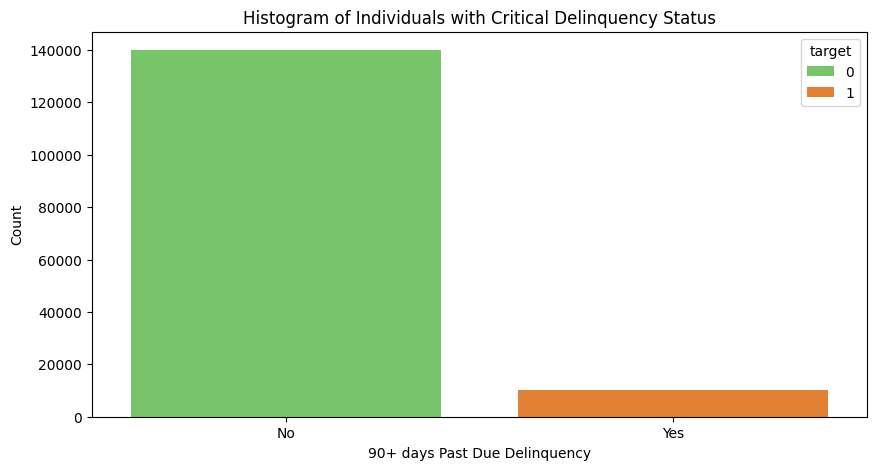

In [8]:
# Make a histogram displaying the counts of the target column

yes_cases = credit_traindf[credit_traindf["target"] == 1].shape[0]
no_cases = credit_traindf[credit_traindf["target"] == 0].shape[0]
total = credit_traindf.shape[0]

yes_cases_percent, no_cases_percent = (yes_cases / total)*100, (no_cases / total)*100

print(f"Individuals in this dataset with 90+ days past due Delinquency: {yes_cases} ({yes_cases_percent:.2f}%)")
print(f"Individuals in this dataset without 90+ days past due Delinquency: {no_cases} ({no_cases_percent:.2f}%)")


plt.figure(figsize = (10,5))
sns.countplot(x = "target",
              data = credit_traindf,
              hue = "target", 
              palette={0 : "#6DD558", 1 : "#FF7C17"})
plt.title("Histogram of Individuals with 90+ days Delinquency Status")
plt.xlabel("90+ days Past Due Delinquency")
plt.ylabel("Count")
plt.xticks(ticks = [0, 1], labels=['No', 'Yes'])
plt.show()

In [9]:
credit_traindf.describe()

,target,credit_util_ratio,age,mod_late_count_2yr,debt_ratio,monthly_income,credit_loans_count,crit_late_count,real_estate_count,sev_late_count_2yr,dependent_count
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


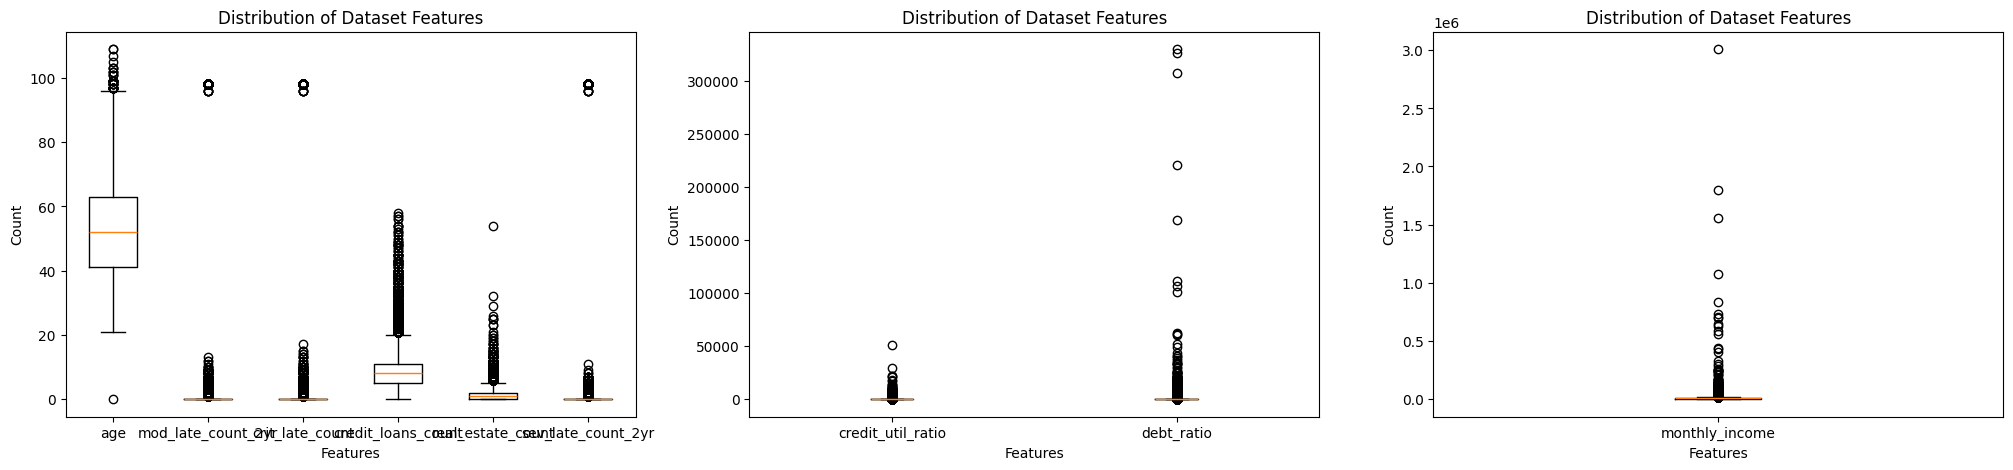

In [10]:
columns_0 = credit_traindf[["age", "mod_late_count_2yr", "crit_late_count", "credit_loans_count", "real_estate_count", "sev_late_count_2yr", ]]
columns_1 = credit_traindf[["credit_util_ratio", "debt_ratio", ]]

fig, ax = plt.subplots(1,3, figsize=(25,5))

ax[0].set_title("Distribution of Dataset Features")
ax[0].boxplot(columns_0)
ax[0].set_xticks(ticks = range(1,7), labels = columns_0)
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Features")

ax[1].set_title("Distribution of Dataset Features")
ax[1].boxplot(columns_1)
ax[1].set_xticks(ticks = range(1,3), labels = columns_1)
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Features")

ax[2].set_title("Distribution of Dataset Features")
ax[2].boxplot(x = credit_traindf["monthly_income"].dropna())
ax[2].set_xticklabels(["monthly_income"])
ax[2].set_ylabel("Count")
ax[2].set_xlabel("Features")


plt.show()

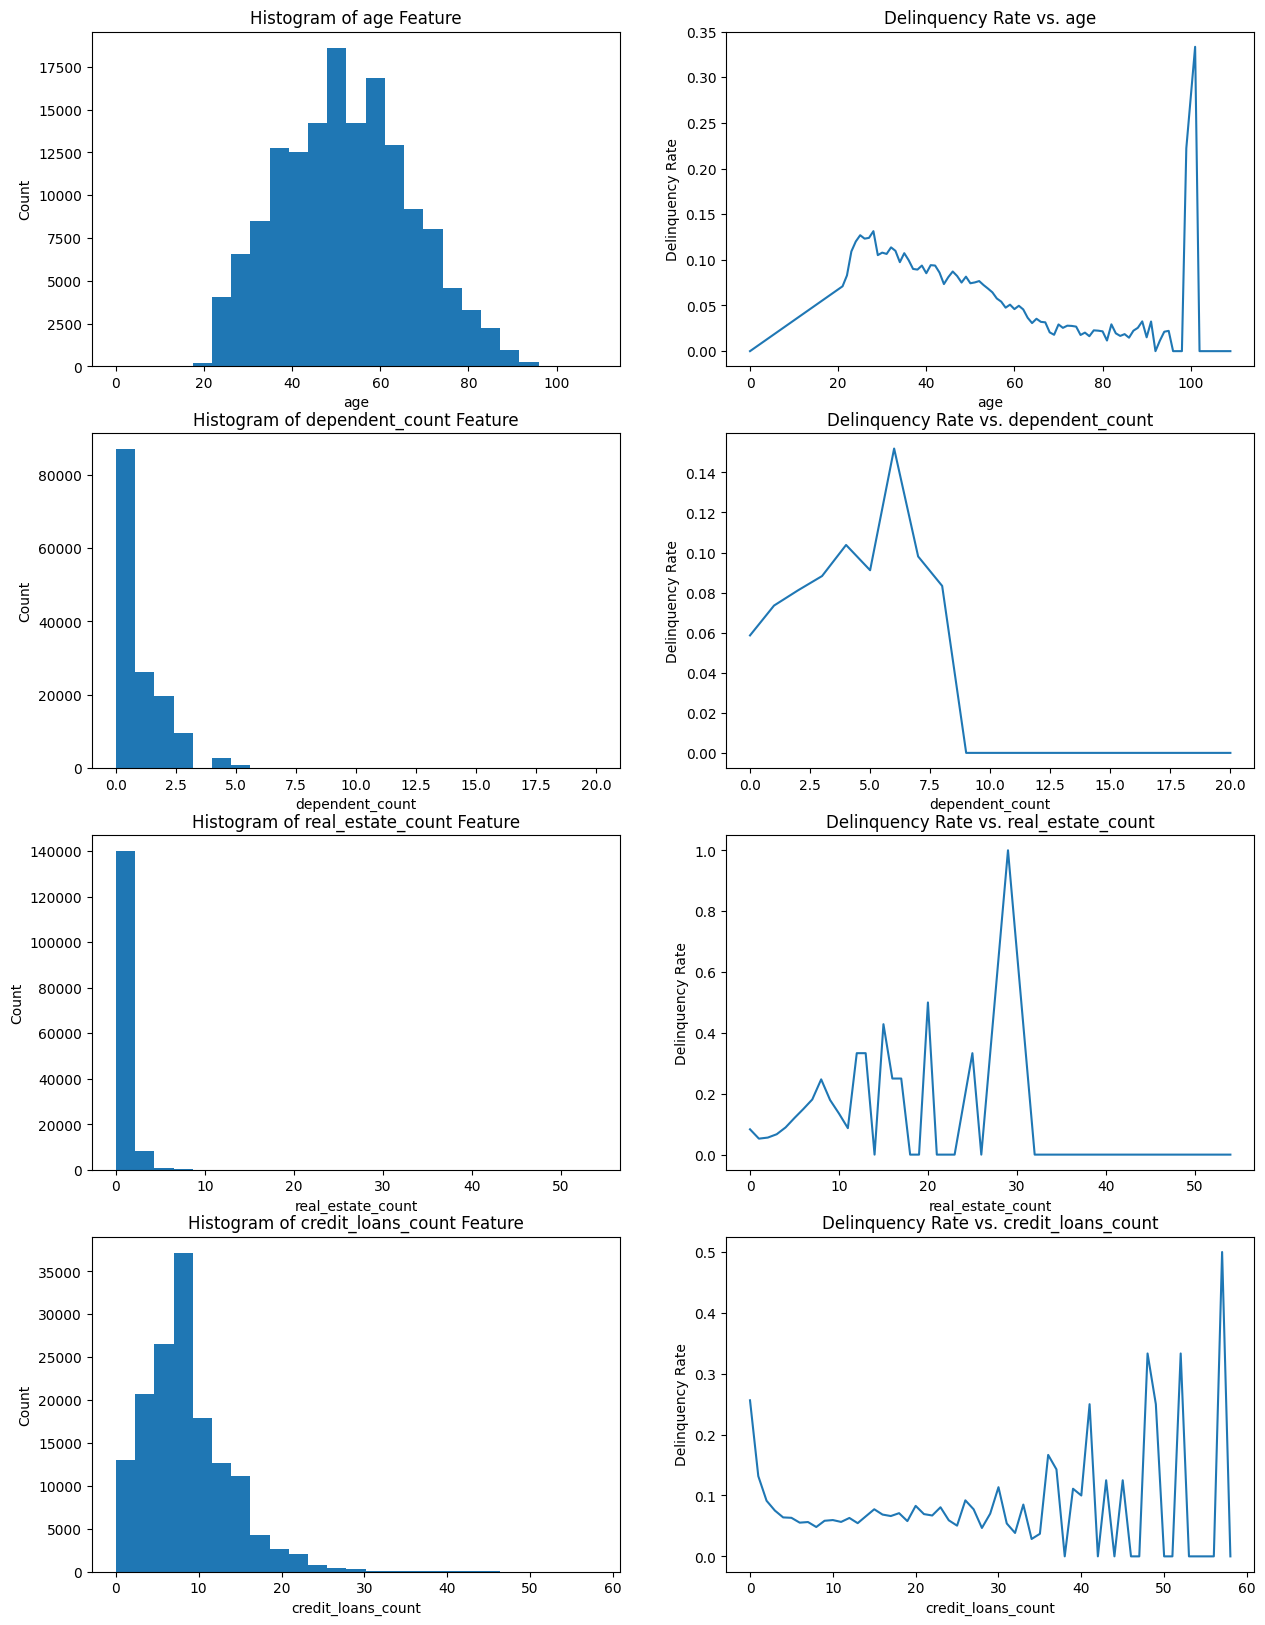

In [27]:
cols_discrete = {"age":[0,1],
                 "dependent_count":[2,3],
                 "real_estate_count":[4,5],
                 "credit_loans_count":[6,7],
                }

fig, ax = plt.subplots(4,2, figsize = (15,20))
ax = ax.flatten()

for key, val in cols_discrete.items() : 
    
    ax[val[0]].hist(credit_traindf[key], bins = 25)
    ax[val[0]].set_xlabel(f"{key}")
    ax[val[0]].set_ylabel("Count")
    ax[val[0]].set_title(f"Histogram of {key} Feature") 
    
    groups = credit_traindf.groupby(key)["target"].mean()
    ax[val[1]].plot(groups.index, groups.values)
    ax[val[1]].set_xlabel(f"{key}")
    ax[val[1]].set_ylabel("Delinquency Rate")
    ax[val[1]].set_title(f"Delinquency Rate vs. {key}")

plt.show()
    

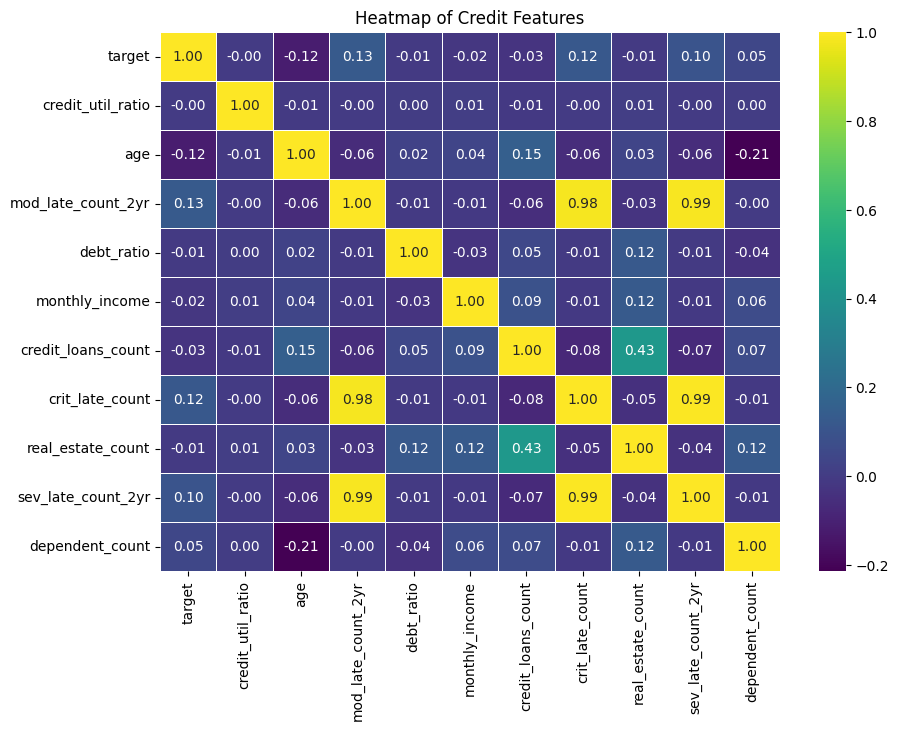

In [14]:
# Create a Heatmap to show correlations between features 
corr_subset = credit_traindf[credit_traindf.columns[:1000]].corr()

plt.figure(figsize=(10, 7)) 
sns.heatmap(corr_subset, annot=True, cmap='viridis', fmt=".2f", linewidths=.5) 
plt.title('Heatmap of Credit Features') 
plt.show()

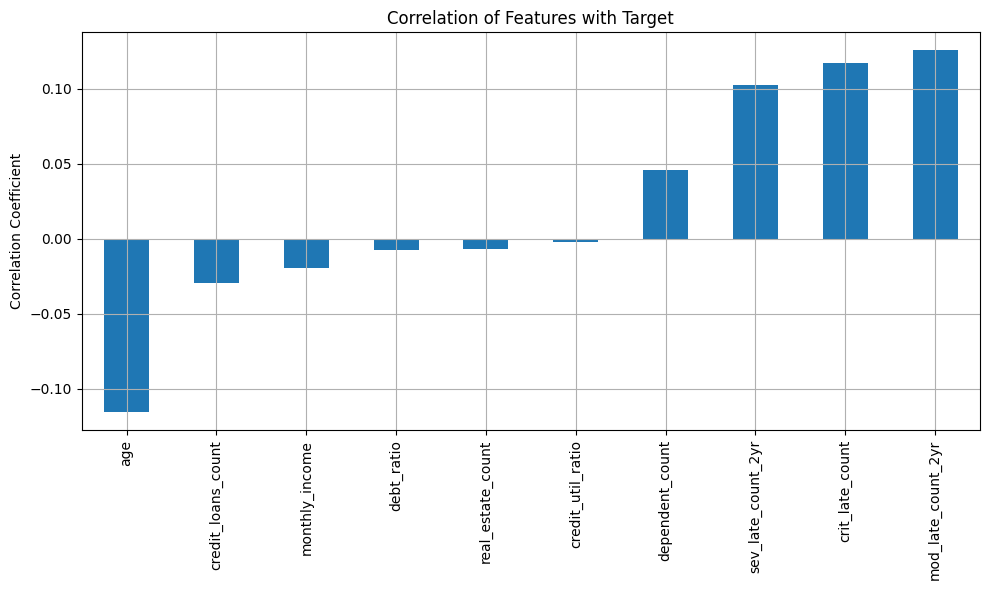

In [26]:
# plot correlations between features and the target

correlations = credit_traindf.corr(numeric_only=True)["target"].sort_values()
correlations = correlations.drop('target')

# Plot
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar')
plt.title("Correlation of Features with Target")
plt.ylabel("Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

### **2. Feature Engineering + Preprocessing**

Before splitting the training set, the following preprocessing steps were applied:
1. **Binary Encoding of Count Features:** Delinquency count features and related dependent count variables were converted into binary indicators. The majority of the values in these features are 0 and only the outliers are above 1. This change simplifies thier use in linear models. 
2. **Clipping Implausible Values:** The 'age' feature is clipped to remove the unsual outliers (0 and over 100).
3. **Feature Binning:** The 'age' feature and various count-based features (including 'credit_loans_count' and 'real_estate_count') were binned into four discrete intervals. This improves interpretability and helps linear models. 
4. **Missingness Indicator:** A binary flag was added to indicate missing values in the 'monthly_income' feature.
5. **Capping Ratio Features and Outlier Flags:** Ratio features (e.g., 'credit_util_ratio', 'debt_ratio') were capped at a maximum of 1, since values above 1 are considered outliers. Corresponding binary outlier indicator features were created.

After preprocessing, a correlation heatmap was generated. The least informative feature, 'debt_ratio_outliers' (which had negligible correlation with other variables or the target), was removed.

In [28]:
traindf = credit_traindf.copy()
testdf = credit_testdf.copy()

In [29]:
def preprocess(df) :

    '''Before splitting, perform preprocessing '''

    # Make the columns binary (0: for zero counts, 1: for 1+ counts) ✓✓
    make_binary_cols = ["crit_late_count", "mod_late_count_2yr", "sev_late_count_2yr", "dependent_count"]

    for col in make_binary_cols : 
        df[col] = (df[col] > 0).astype(int)
        # (df[col] > 0) returns a series of booleans, which is turned into 1 (True) or 0 (False)


    # Remove bad rows from the age column (above 100, less than 18 years old) ✓✓
    df["age_clipped"] = df["age"].clip(upper=100, lower=18)
    #df = df.drop(columns = "age") 

    # Binning Age, credit loans, real estate bin ✓✓
    df['age_bin'] = pd.cut(df['age_clipped'], 
                           bins=[-float('inf'), 30, 45, 60, float('inf')], 
                           labels=False)
    
    df['credit_bin'] = pd.cut(df['credit_loans_count'], 
                              bins=[-float('inf'), 5, 25, 40, float('inf')], 
                              labels=False)

    df['real_estate_bin'] = pd.cut(df['real_estate_count'], 
                                   bins=[-float('inf'), 10, 20, 30, float('inf')], 
                                   labels=False)


    remove_col = ["age_clipped","age", "credit_loans_count", "real_estate_count"]
    df = df.drop(columns = remove_col)

    # Add a missingness flag for the monthly_income column ✓✓
    df["mon_income_miss"] = df["monthly_income"].isna().astype(int)

    # cap the ratio columns at 1, and flag any rows > 1 in a new feature ✓✓
    ratio_cols = ["credit_util_ratio", "debt_ratio"]

    for col in ratio_cols : 
        df[f"{col}_outliers"] = (df[col] > 1).astype(int)
        df.loc[df[col] > 1, col] = 1


    return df

In [30]:
traindf_processed = preprocess(traindf)
testdf_preprocessed = preprocess(testdf)

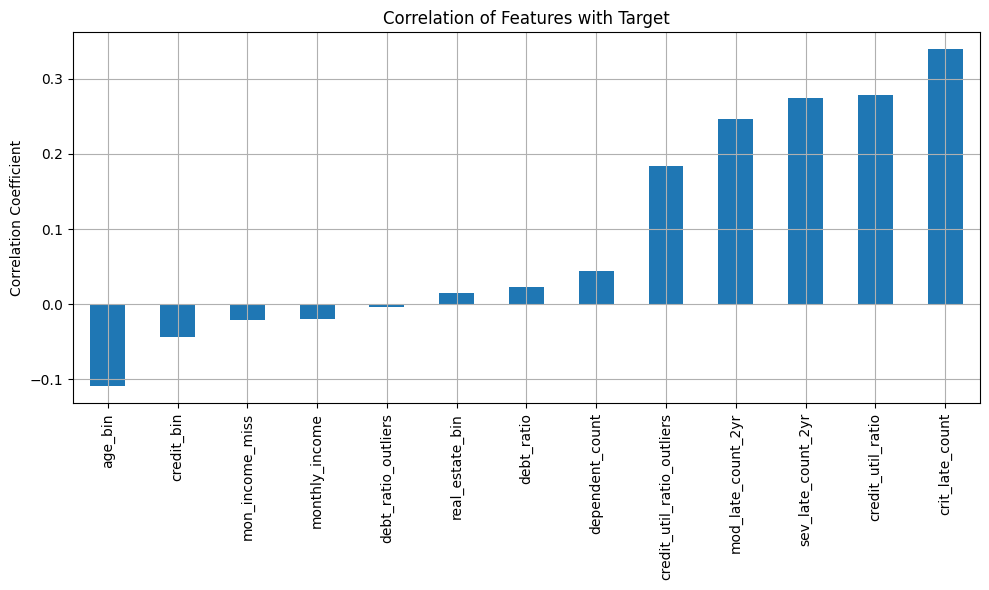

In [31]:
correlations = traindf_processed.corr(numeric_only=True)["target"].sort_values()
correlations = correlations.drop('target')

# Plot
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar')
plt.title("Correlation of Features with Target")
plt.ylabel("Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
traindf_processed = traindf_processed.drop(columns = ["debt_ratio_outliers"])

### **3. Train-Test Splitting and Processing**

In [37]:
# Split the training set into a testing and training set to get validation
X = traindf_processed.drop(columns = ["target"])
y = traindf_processed["target"]

# splitting on 0.5 because we have a lot of data and it's slowing down the downstream processing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=123)

In [38]:
X_train["monthly_income_log"] = np.log1p(X_train["monthly_income"])
X_test["monthly_income_log"] = np.log1p(X_test["monthly_income"])

### **4. Generate Column Transformer and Scoring Functions**

In [39]:
scaling_cols = ["credit_util_ratio","debt_ratio","monthly_income_log"]
oh_cols = ["age_bin", "credit_bin", "real_estate_bin"]
binary_cols = ["dependent_count", "mod_late_count_2yr", "crit_late_count", "sev_late_count_2yr", "credit_util_ratio_outliers"]
drop_cols = ["monthly_income"]


# Pipelines
scaling_pipeline = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

oh_pipeline = make_pipeline(
    SimpleImputer(),
    OneHotEncoder(sparse_output=False, handle_unknown="ignore")
)

binary_pipeline = OneHotEncoder(drop='if_binary', dtype=int)

# Column transformer
preprocessor = make_column_transformer(
    (scaling_pipeline, scaling_cols),
    (oh_pipeline, oh_cols),
    (binary_pipeline, binary_cols),
    ("drop", drop_cols)
)

In [40]:
def cross_validate_mean_std(model, X, y) :
    '''Performs 5-fold cross-validation and returns train/test mean ± std as formatted strings.'''

    scr = cross_validate(model, X, y, cv=5, return_train_score=True, scoring=("f1", "precision", "recall"))

    result = {}

    result = {
        "test_score_f1" : f"{scr['test_f1'].mean():.2f} +/- {scr['test_f1'].std():.3f}",
        "train_score_f1" : f"{scr['train_f1'].mean():.2f} +/- {scr['train_f1'].std():.3f}",

        "test_score_precision" : f"{scr['test_precision'].mean():.2f} +/- {scr['test_precision'].std():.3f}",
        "train_score_precision" : f"{scr['train_precision'].mean():.2f} +/- {scr['train_precision'].std():.3f}",

        "test_score_recall" : f"{scr['test_recall'].mean():.2f} +/- {scr['test_recall'].std():.3f}",
        "train_score_recall" : f"{scr['train_recall'].mean():.2f} +/- {scr['train_recall'].std():.3f}"
    }

    return result

In [35]:
scores = {}

### **5. Baseline Model - Dummy Classifier, Decision Tree**

The dummy classifier exhibits poor predicition scores for f1 and precision metrics, and approximatly 50% recall. The values are simular across training and testing results, which does not indicate overfitting. Conversly, the decision tree yeilded strong results for training scores (approximately 95-99%) but shows significantly lower scores on the test set (~20%), suggesting the model is overfitting to the training data. 

In [41]:
# The results are expected if the dummy are choosing the 0 class more often
dummy = DummyClassifier(strategy="uniform")
dummy_pipe = make_pipeline(preprocessor, dummy)

scores["dummy classifier"] = cross_validate_mean_std(dummy_pipe, X_train, y_train)

In [43]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(
    random_state=123
))

scores["decision tree"] = cross_validate_mean_std(pipe_dt, X_train, y_train)
pd.DataFrame(scores).T

,test_score_f1,train_score_f1,test_score_precision,train_score_precision,test_score_recall,train_score_recall
dummy classifier,0.12 +/- 0.003,0.12 +/- 0.002,0.07 +/- 0.002,0.07 +/- 0.001,0.51 +/- 0.013,0.50 +/- 0.008
decision tree,0.25 +/- 0.017,0.97 +/- 0.001,0.25 +/- 0.016,0.99 +/- 0.002,0.26 +/- 0.019,0.96 +/- 0.002


### **6. Linear Model - Linear Regression**

In [30]:
c_dict = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100]
}

linear_model_dict = {}

for c in c_dict["C"] :
    model = LogisticRegression(C = c, class_weight='balanced', max_iter=1000)
    linear_pipe = make_pipeline(preprocessor,  model)
    linear_model_dict[f"Linear model C{c}"] = cross_validate_mean_std(linear_pipe, X_train, y_train)

In [31]:

pipe_lr = make_pipeline(preprocessor, LogisticRegression(
    class_weight='balanced',
    max_iter=1000
))

scores["linear regression"] = cross_validate_mean_std(pipe_lr, X_train, y_train)
pd.DataFrame(scores).T

,test_score_f1,train_score_f1,test_score_precision,train_score_precision,test_score_recall,train_score_recall
dummy classifier,0.12 +/- 0.004,0.12 +/- 0.002,0.07 +/- 0.002,0.07 +/- 0.001,0.50 +/- 0.019,0.50 +/- 0.008
decision tree,0.25 +/- 0.017,0.97 +/- 0.001,0.25 +/- 0.016,0.99 +/- 0.002,0.26 +/- 0.019,0.96 +/- 0.002
linear regression,0.33 +/- 0.005,0.33 +/- 0.001,0.21 +/- 0.004,0.21 +/- 0.001,0.73 +/- 0.009,0.74 +/- 0.001


### Ensembles

In [32]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(
    n_jobs = -1,
    random_state = 123,
    n_estimators=100,
    class_weight = "balanced"
))

scores["RFC"] = cross_validate_mean_std(pipe_rf, X_train, y_train)
pd.DataFrame(scores).T

,test_score_f1,train_score_f1,test_score_precision,train_score_precision,test_score_recall,train_score_recall
dummy classifier,0.12 +/- 0.004,0.12 +/- 0.002,0.07 +/- 0.002,0.07 +/- 0.001,0.50 +/- 0.019,0.50 +/- 0.008
decision tree,0.25 +/- 0.017,0.97 +/- 0.001,0.25 +/- 0.016,0.99 +/- 0.002,0.26 +/- 0.019,0.96 +/- 0.002
linear regression,0.33 +/- 0.005,0.33 +/- 0.001,0.21 +/- 0.004,0.21 +/- 0.001,0.73 +/- 0.009,0.74 +/- 0.001
RFC,0.26 +/- 0.013,0.94 +/- 0.003,0.38 +/- 0.016,0.89 +/- 0.007,0.20 +/- 0.014,0.99 +/- 0.001


In [40]:
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(
    random_state=123, 
    verbose=-1,
    is_unbalance=True
))

pipe_histGB = make_pipeline(preprocessor, HistGradientBoostingClassifier(
    random_state=123,
    class_weight="balanced"
))

scores["lgbm"] = cross_validate_mean_std(pipe_rf, X_train, y_train)
scores["histGB"] = cross_validate_mean_std(pipe_rf, X_train, y_train)
pd.DataFrame(scores).T

,test_score_f1,train_score_f1,test_score_precision,train_score_precision,test_score_recall,train_score_recall
dummy classifier,0.12 +/- 0.004,0.12 +/- 0.002,0.07 +/- 0.002,0.07 +/- 0.001,0.50 +/- 0.019,0.50 +/- 0.008
decision tree,0.25 +/- 0.017,0.97 +/- 0.001,0.25 +/- 0.016,0.99 +/- 0.002,0.26 +/- 0.019,0.96 +/- 0.002
linear regression,0.33 +/- 0.005,0.33 +/- 0.001,0.21 +/- 0.004,0.21 +/- 0.001,0.73 +/- 0.009,0.74 +/- 0.001
RFC,0.26 +/- 0.013,0.94 +/- 0.003,0.38 +/- 0.016,0.89 +/- 0.007,0.20 +/- 0.014,0.99 +/- 0.001
lgbm,0.26 +/- 0.013,0.94 +/- 0.003,0.38 +/- 0.016,0.89 +/- 0.007,0.20 +/- 0.014,0.99 +/- 0.001
histGB,0.26 +/- 0.013,0.94 +/- 0.003,0.38 +/- 0.016,0.89 +/- 0.007,0.20 +/- 0.014,0.99 +/- 0.001


#### Hyperparameter Tuning

In [34]:
rcf_param_grid = {
    "randomforestclassifier__n_estimators": [100, 200, 500],
    "randomforestclassifier__max_depth": [5, 10, 20, 30],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
    "randomforestclassifier__bootstrap": [True, False]
}

In [35]:
scoring = ["precision", "recall", "f1"]


rcf_search = RandomizedSearchCV(pipe_rf,
                                param_distributions=rcf_param_grid,
                                scoring = scoring,
                                refit = "f1",
                                n_iter=6,
                                n_jobs=-1,
                                return_train_score=True,
                                random_state=123,
                                cv=3,
                                verbose=2)

rcf_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,estimator,Pipeline(step..._state=123))])
,param_distributions,"{'randomforestclassifier__bootstrap': [True, False], 'randomforestclassifier__max_depth': [5, 10, ...], 'randomforestclassifier__min_samples_leaf': [1, 2, ...], 'randomforestclassifier__min_samples_split': [2, 5, ...], ...}"
,n_iter,6
,scoring,"['precision', 'recall', ...]"
,n_jobs,-1
,refit,'f1'
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,123
,error_score,nan


In [36]:
pd.DataFrame(rcf_search.cv_results_)[["mean_test_recall", 
                                      "mean_test_f1",
                                      "mean_test_precision",
                                      "param_randomforestclassifier__n_estimators",
                                      "param_randomforestclassifier__max_depth",
                                      "param_randomforestclassifier__min_samples_split",
                                      "param_randomforestclassifier__min_samples_leaf",
                                      "param_randomforestclassifier__bootstrap"
                                      ]].T

,0,1,2,3,4,5
mean_test_recall,0.394375,0.388789,0.685617,0.754438,0.388789,0.73469
mean_test_f1,0.34369,0.353553,0.337419,0.320151,0.377058,0.331156
mean_test_precision,0.304693,0.324185,0.223775,0.203204,0.366078,0.21376
param_randomforestclassifier__n_estimators,100,100,200,500,100,100
param_randomforestclassifier__max_depth,20,30,10,5,30,10
param_randomforestclassifier__min_samples_split,2,5,5,2,5,10
param_randomforestclassifier__min_samples_leaf,2,2,1,4,2,4
param_randomforestclassifier__bootstrap,False,False,True,False,True,False


In [37]:
lgbm_param_grid = {
    "lgbmclassifier__n_estimators": [100, 300, 500],
    "lgbmclassifier__learning_rate": [0.01, 0.05, 0.1],
    "lgbmclassifier__max_depth": [-1, 5, 10, 20],
    "lgbmclassifier__num_leaves": [15, 31, 63],
    "lgbmclassifier__min_child_samples": [10, 20, 40],
    "lgbmclassifier__subsample": [0.6, 0.8, 1.0],
    "lgbmclassifier__colsample_bytree": [0.6, 0.8, 1.0],
    "lgbmclassifier__reg_alpha": [0.0, 0.1, 1.0],
    "lgbmclassifier__reg_lambda": [0.0, 0.1, 1.0]
}

In [38]:
scoring = ["precision", "recall", "f1"]


lgbm_search = RandomizedSearchCV(pipe_lgbm,
                                param_distributions=lgbm_param_grid,
                                scoring = scoring,
                                refit = "f1",
                                n_iter=6,
                                n_jobs=-1,
                                return_train_score=True,
                                random_state=123,
                                cv=3,
                                verbose=2)

lgbm_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,estimator,Pipeline(step...verbose=-1))])
,param_distributions,"{'lgbmclassifier__colsample_bytree': [0.6, 0.8, ...], 'lgbmclassifier__learning_rate': [0.01, 0.05, ...], 'lgbmclassifier__max_depth': [-1, 5, ...], 'lgbmclassifier__min_child_samples': [10, 20, ...], ...}"
,n_iter,6
,scoring,"['precision', 'recall', ...]"
,n_jobs,-1
,refit,'f1'
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,123
,error_score,nan


In [39]:
pd.DataFrame(lgbm_search.cv_results_)[["mean_test_recall", 
                                      "mean_test_f1",
                                      "mean_test_precision",
                                      "param_lgbmclassifier__n_estimators",
                                      "param_lgbmclassifier__learning_rate",
                                      "param_lgbmclassifier__max_depth",
                                      "param_lgbmclassifier__num_leaves",
                                      "param_lgbmclassifier__min_child_samples",
                                      "param_lgbmclassifier__subsample",
                                      "param_lgbmclassifier__colsample_bytree",
                                      "param_lgbmclassifier__reg_alpha",
                                      "param_lgbmclassifier__reg_lambda"
                                      ]].T

,0,1,2,3,4,5
mean_test_recall,0.534012,0.702174,0.727110,0.705765,0.749651,0.549970
mean_test_f1,0.414085,0.335886,0.338520,0.334997,0.326030,0.349913
mean_test_precision,0.338213,0.220745,0.220639,0.219627,0.208321,0.256594
param_lgbmclassifier__n_estimators,100.000000,500.000000,500.000000,500.000000,100.000000,500.000000
param_lgbmclassifier__learning_rate,0.010000,0.100000,0.010000,0.050000,0.100000,0.100000
param_lgbmclassifier__max_depth,20.000000,5.000000,-1.000000,5.000000,5.000000,10.000000
param_lgbmclassifier__num_leaves,31.000000,15.000000,63.000000,63.000000,63.000000,63.000000
param_lgbmclassifier__min_child_samples,20.000000,20.000000,10.000000,20.000000,10.000000,20.000000
param_lgbmclassifier__subsample,0.800000,1.000000,0.600000,1.000000,1.000000,1.000000
param_lgbmclassifier__colsample_bytree,1.000000,0.800000,1.000000,1.000000,0.800000,0.600000
